<a href="https://colab.research.google.com/github/yeoun9/torchpm/blob/main/examples/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install git+https://github.com/yeoun9/torchpm.git
! pip install sympytorch

In [1]:
from torchpm import *
from torchpm.data import CSVDataset
from torchpm.estimated_parameter import *
import torch as tc
import numpy as np
import matplotlib.pyplot as plt

# Model Building

In [3]:
class BasementModel(predfunction.PredictionFunctionByTime) :
    '''
        pass
    '''
    def _set_estimated_parameters(self):
        self.theta_0 = Theta(0., 1.5, 10.)
        self.theta_1 = Theta(0., 30., 100.)
        self.theta_2 = Theta(0, 0.08, 1)

        self.eta_0 = Eta()
        self.eta_1 = Eta()
        self.eta_2 = Eta()

        self.eps_0 = Eps()
        self.eps_1 = Eps()

        self.gut_model = linearode.Comp1GutModelFunction()
    
    def _calculate_parameters(self, covariates):
        covariates['k_a'] = self.theta_0()*tc.exp(self.eta_0())
        covariates['v'] = self.theta_1()*tc.exp(self.eta_1())#*para['BWT']/70
        covariates['k_e'] = self.theta_2()*tc.exp(self.eta_2())
        covariates['AMT'] = tc.tensor(320., device=self.dataset.device)

    def _calculate_preds(self, t, p):
        dose = p['AMT'][0]
        k_a = p['k_a']
        v = p['v']
        k_e = p['k_e']
        comps = self.gut_model(t, k_a, k_e, dose)
        return comps[1]/v
        
    def _calculate_error(self, y_pred, p):
        p['v_v'] = p['v'] 
        return y_pred +  y_pred * self.eps_0() + self.eps_1()

dataset_file_path = 'https://raw.githubusercontent.com/yeoun9/torchpm/main/examples/THEO.csv'
# dataset_file_path = './examples/THEO.csv'
dataset_np = np.loadtxt(dataset_file_path, delimiter=',', dtype=np.float32, skiprows=1)



device = tc.device("cuda:0" if tc.cuda.is_available() else "cpu")
column_names = ['ID', 'AMT', 'TIME', 'DV', 'CMT', "MDV", "RATE", 'BWT']
dataset = CSVDataset(dataset_np, column_names, device)

pred_function_module = BasementModel(dataset = dataset,
                            output_column_names=['ID', 'TIME', 'AMT', 'k_a', 'v', 'k_e'])

omega = Omega([0.4397,
                0.0575,  0.0198, 
                -0.0069,  0.0116,  0.0205], False, requires_grads=False)
sigma = Sigma([[0.0177], [0.0762]], [True, True], requires_grads=[False, True])

model = models.FOCEInter(pred_function_module, 
                        theta_names=['theta_0', 'theta_1', 'theta_2'],
                        eta_names= ['eta_0', 'eta_1','eta_2'], 
                        eps_names= ['eps_0','eps_1'], 
                        omega=omega, 
                        sigma=sigma)
                        
model = model.to(device)
model.fit_population(learning_rate = 1, tolerance_grad = 1e-5, tolerance_change= 1e-3)
#TODO 주의사항 다운로드 할때 캐쉬 파일이 있으면 업데이트가 되지 않아서 이상하게 계산되는 경우가 있으니 주의해야함.



TypeError: object of type 'bool' has no len()

#Model Fitting

In [11]:
model.fit_population(learning_rate = 1, tolerance_grad = 1e-3, tolerance_change= 1e-3)

running_time :  0.6299943923950195 	 total_loss: tensor(566.1776, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  1.2259962558746338 	 total_loss: tensor(350.9283, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  1.8109962940216064 	 total_loss: tensor(300.0184, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  2.4049956798553467 	 total_loss: tensor(202.7841, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  2.9959962368011475 	 total_loss: tensor(182.7455, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  3.59899640083313 	 total_loss: tensor(184.5352, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  4.196995496749878 	 total_loss: tensor(170.2930, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  4.786994457244873 	 total_loss: tensor(167.5889, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  5.379995107650757 	 total_loss: tensor(158.6087, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  5.972994565963745 	 total_

FOCEInter(
  (pred_function_module): BasementModel(
    (theta_0): Theta()
    (theta_1): Theta()
    (theta_2): Theta()
    (eta_0): Eta(
      (parameter_values): ParameterDict(
          (1): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (2): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (3): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (4): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (5): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (6): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (7): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (8): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (9): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (10): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (11): Parameter con

# Result

time-pred


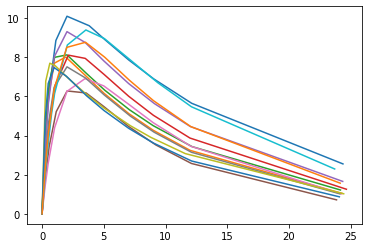

time-cwres


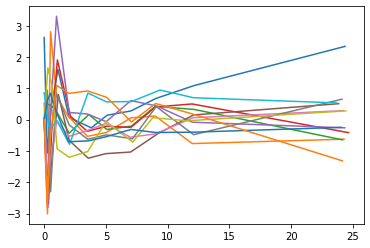

In [12]:
eval_result = model.descale().evaluate()

print('time-pred')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for id, time_data in eval_result['times'].items() :
    y_pred = eval_result['preds'][id]
    ax.plot(time_data.to('cpu'), y_pred.detach().to('cpu').numpy())
plt.show()

print('time-cwres')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for id, time_data in eval_result['times'].items() :
    cwres_value = eval_result['cwress'][id]
    ax.plot(time_data.masked_select(eval_result['mdv_masks'][id]).to('cpu'), cwres_value.detach().to('cpu').numpy())
plt.show()

In [13]:
for k, v in eval_result.items():
    print(k)
    print(v)

total_loss
tensor(92.1740, device='cuda:0')
losses
{'1': 19.735280990600586, '2': 17.681468963623047, '3': -1.2415313720703125, '4': 9.392454147338867, '5': 20.278871536254883, '6': 4.0517730712890625, '7': 1.2484016418457031, '8': 3.9950389862060547, '9': 3.1682662963867188, '10': 4.7196502685546875, '11': -2.3254613876342773, '12': 11.469743728637695}
times
{'1': tensor([ 0.0000,  0.0000,  0.2500,  0.5700,  1.1200,  2.0200,  3.8200,  5.1000,
         7.0300,  9.0500, 12.1200, 24.3700], device='cuda:0'), '2': tensor([ 0.0000,  0.0000,  0.2700,  0.5200,  1.0000,  1.9200,  3.5000,  5.0200,
         7.0300,  9.0000, 12.0000, 24.3000], device='cuda:0'), '3': tensor([ 0.0000,  0.0000,  0.2700,  0.5800,  1.0200,  2.0200,  3.6200,  5.0800,
         7.0700,  9.0000, 12.1500, 24.1700], device='cuda:0'), '4': tensor([ 0.0000,  0.0000,  0.3500,  0.6000,  1.0700,  2.1300,  3.5000,  5.0200,
         7.0200,  9.0200, 11.9800, 24.6500], device='cuda:0'), '5': tensor([ 0.0000,  0.0000,  0.3000,  0.52

In [14]:
cov_result = model.descale().covariance_step()
print(cov_result)

id 1
id 2
id 3
id 4
id 5
id 6
id 7
id 8
id 9
id 10
id 11
id 12
{'cov': tensor([[ 3.3649e-03,  2.3350e-02, -1.4427e-04,  9.2523e-04,  7.6964e-05,
          8.3150e-05,  1.9451e-05,  1.8720e-04,  3.7894e-04, -3.8934e-04,
          3.4469e-03],
        [ 2.3337e-02,  2.9917e-01, -1.2933e-03,  6.1674e-04, -3.3816e-03,
          7.7208e-05, -2.5051e-03,  1.3254e-03,  2.4804e-03, -9.5198e-04,
          9.3650e-03],
        [-1.4429e-04, -1.2937e-03,  7.0336e-06, -6.6909e-06,  7.0362e-06,
         -2.7008e-06,  3.3581e-06, -8.7742e-06, -1.6374e-05,  1.3982e-05,
         -1.2061e-04],
        [ 9.2174e-04,  5.9845e-04, -6.5159e-06,  2.7081e-02,  3.5060e-03,
          2.4872e-04, -2.5002e-04, -2.2030e-04, -4.1426e-04, -1.6837e-04,
         -2.7103e-03],
        [ 7.6045e-05, -3.3854e-03,  7.0771e-06,  3.5047e-03,  6.6868e-04,
          6.4217e-05,  2.0591e-04, -2.0642e-05, -7.0011e-05, -4.3176e-05,
         -1.8787e-04],
        [ 8.3068e-05,  7.7349e-05, -2.6997e-06,  2.4909e-04,  6.4338e-05,


In [15]:
for (name, para) in model.named_parameters():
    print(name)
    print(para.detach().clone().to('cpu').numpy())

pred_function_module.theta_0.parameter_value
1.4718726
pred_function_module.theta_1.parameter_value
32.40079
pred_function_module.theta_2.parameter_value
0.08719524
pred_function_module.eta_0.parameter_values.1
-0.07154487
pred_function_module.eta_0.parameter_values.2
0.3483257
pred_function_module.eta_0.parameter_values.3
0.43453595
pred_function_module.eta_0.parameter_values.4
-0.3269742
pred_function_module.eta_0.parameter_values.5
-0.016243443
pred_function_module.eta_0.parameter_values.6
-0.44527635
pred_function_module.eta_0.parameter_values.7
-0.838333
pred_function_module.eta_0.parameter_values.8
-0.034315236
pred_function_module.eta_0.parameter_values.9
1.42991
pred_function_module.eta_0.parameter_values.10
-0.69259745
pred_function_module.eta_0.parameter_values.11
0.88521594
pred_function_module.eta_0.parameter_values.12
-0.49759862
pred_function_module.eta_1.parameter_values.1
-0.1792255
pred_function_module.eta_1.parameter_values.2
0.05520005
pred_function_module.eta_1.para

#Simulation

In [ ]:
tc.manual_seed(42)
simulation_result = model.simulate(dataset, 300)
fig = plt.figure()
for id, values in simulation_result.items() :
    ax = fig.add_subplot(1, 1, 1)
    print('id', id)
    time_data : tc.Tensor = values['time'].to('cpu')
    
    preds : List[tc.Tensor] = values['preds']
    preds_tensor = tc.stack(preds).to('cpu')
    p95 = np.percentile(preds_tensor, 95, 0)
    p50 = np.percentile(preds_tensor, 50, 0)
    average = np.average(preds_tensor, 0)
    p5 = np.percentile(preds_tensor, 5, 0)
    
    ax.plot(time_data, p95, color="black")
    ax.plot(time_data, p50, color="green")
    ax.plot(time_data, average, color="red")
    ax.plot(time_data, p5, color="black")

    for y_pred in values['preds'] :
        ax.plot(time_data, y_pred.detach().to('cpu'), marker='.', linestyle='', color='gray')
plt.show()

id 1


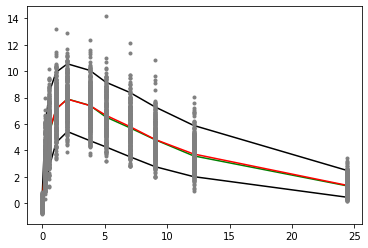

id 2


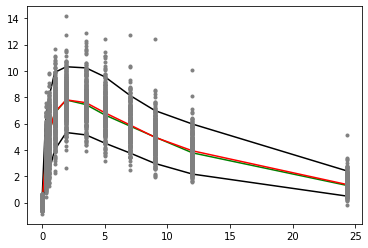

id 3


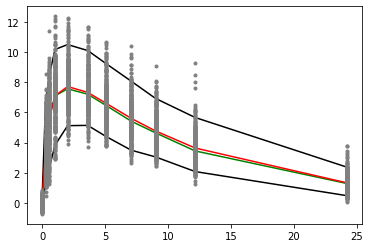

id 4


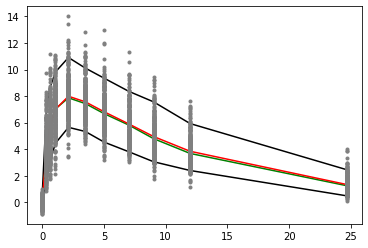

id 5


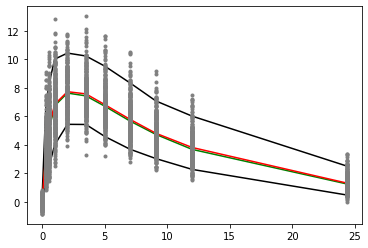

id 6


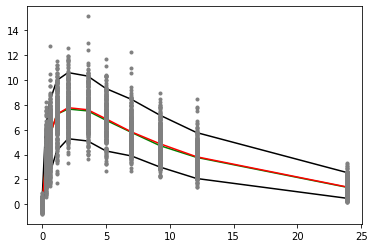

id 7


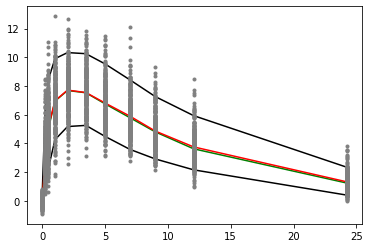

id 8


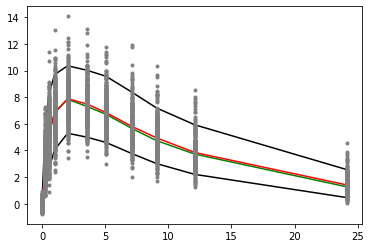

id 9


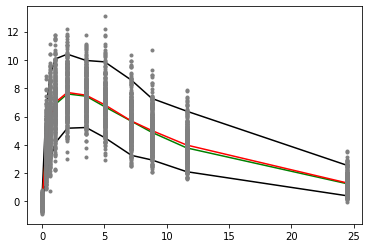

id 10


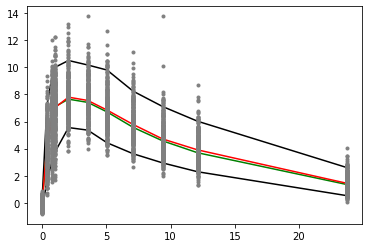

id 11


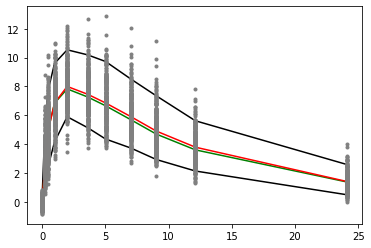

id 12


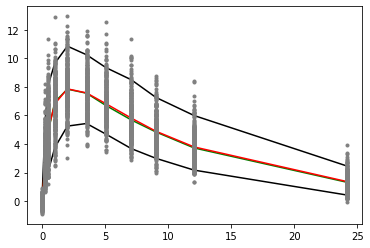

In [33]:
tc.manual_seed(42)
simulation_result = model.simulate(dataset, 300)

for id, time_data in simulation_result['times'].items() :
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    print('id', id)
    
    p95 = np.percentile(tc.stack(simulation_result['preds'][id]).to('cpu'), 95, 0)
    p50 = np.percentile(tc.stack(simulation_result['preds'][id]).to('cpu'), 50, 0)
    average = np.average(tc.stack(simulation_result['preds'][id]).to('cpu'), 0)
    p5 = np.percentile(tc.stack(simulation_result['preds'][id]).to('cpu'), 5, 0)
    
    ax.plot(time_data.to('cpu'), p95, color="black")
    ax.plot(time_data.to('cpu'), p50, color="green")
    ax.plot(time_data.to('cpu'), average, color="red")
    ax.plot(time_data.to('cpu'), p5, color="black")
    
    for y_pred in simulation_result['preds'][id] :
        ax.plot(time_data.to('cpu'), y_pred.detach().to('cpu'), marker='.', linestyle='', color='gray')
    plt.show()